<a href="https://colab.research.google.com/github/stchang-idm/nutrition_tb_workshop/blob/main/sample_size_calculations_2_3_4_arm_designs_2025_01_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Size Calculation for Two- and Multi-Arm Trials Comparing Control and Micro/Macro Nutrient Interventions

### Authors
- *Stewart Chang* (<stewart.chang@gatesfoundation.org>)
- *Arie Voorman* (<arend.voorman@gatesfoundation.org>)

## Introduction

This notebook demonstrates **sample size calculations** for **two-arm** and **multi-arm** nutritional intervention trials that compare a **Control** arm vs. various **micronutrient** and/or **macronutrient** interventions. Scenarios differ by:

1. **Randomization Level**: Cluster-level vs. household-level.
2. **Number of Arms**: 2-arm, 3-arm, or 4-arm designs.
3. **ICC Values**: Typical assumed ICC vs. **observed** ICC from the RATIONS trial.
4. **Low-BMI Sensitivity** (Scenario 2B).

We produce **heatmaps** of total sample sizes across **baseline incidence** and **efficacy** ranges. Based on RATIONS trial assumptions, we highlight a **reference assumption** of 5% baseline incidence and 50% efficacy in each heatmap with a **red box**.

### Number of Arms and Bonferroni Correction
- **2-Arm**: Single comparison => no multiple-comparison correction.
- **3-Arm**: 2 comparisons vs. Control => $(k=2)$ => $\alpha_{\mathrm{adj}} = \alpha/2$.
- **4-Arm**: 3 comparisons vs. Control => $(k=3)$ => $\alpha_{\mathrm{adj}} = \alpha/3$.

We assume **all interventions** in multi-arm designs have a *common* efficacy so that the sample-size for each comparison is identical, enabling a single 2D heatmap.

### Outline of Scenarios
1. **Scenario 1**: Cluster-Level, 2-arm
2. **Scenario 2**: Household-Level, 2-arm
3. **Scenario 2B**: Household-Level, 2-arm with Low-BMI subgroups
4. **Scenario 3**: Observed ICC from RATIONS, 2-arm
5. **Scenario 4**: Cluster-Level, 3-arm
6. **Scenario 5**: Household-Level, 3-arm
7. **Scenario 6**: Cluster-Level, 4-arm
8. **Scenario 7**: Household-Level, 4-arm

---
## Key Assumptions

- **Significance Level** $(\alpha = 0.05)$
- **Power** $(1-\beta = 0.80)$
- **Baseline Incidence** range from 3% to 7.5% in 0.5 increments.
- **Efficacy** range from 25% to 55% in 5% increments (for the general heatmaps).
- **ICC**: Typical $(r=0.2,\rho=0.01)$ vs. Observed $(r=0.0036,\rho=0.0018)$
- **Bonferroni** for multi-arm: If we have $k$ comparisons vs. Control, $\alpha_{\mathrm{adj}} = \alpha / k$.

---

## Basic Algorithm

1. **Adjust Significance Level** (if multiple comparisons): Possibly use Bonferroni (or another approach) to adjust $\alpha$.
2. **Calculate Z-Scores**:
$$ Z_{\alpha} = Z_{1 - \alpha/2}, \quad Z_{\beta} = Z_{1 - \beta}. $$
3. **Define Incidence Rates**:
$$ p_1 = p_{\text{control}}, \quad p_2 = p_{\text{control}}(1 - \text{eff}_{\text{Micro-Alone}}). $$
4. **Effect Size**: $\delta = p_1 - p_2$.
5. **Sample Size Without Clustering**:
$$ n = \frac{(Z_{\alpha} + Z_{\beta})^2 [p_1(1 - p_1) + p_2(1 - p_2)]}{\delta^2}. $$
6. **Design Effect**:
- Cluster-Level (Teerenstra 2010): $\text{DE} = 1 + (n_e - 1)r + n_e(n_s - 1)\rho$.
- Household-Level: $\text{DE} = 1 + (n_e - 1)r$.
7. **Adjusted Sample Size**: $n_{\text{adjusted}} = n \times \text{DE}$.
8. **Generate 2D Heatmaps**.

---

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

%matplotlib inline

# Set global font sizes for better readability.
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 18,
    'legend.fontsize': 14
})

sns.set_style("whitegrid")

## Global Parameters

In [2]:
alpha = 0.05
power = 0.80
# z-value for power.
Z_beta = stats.norm.ppf(power)

# Baseline incidence from 3%..7.5% in 0.5 increments.
baseline_incidence_percent = np.arange(3, 7.5, 0.5)
baseline_incidences = baseline_incidence_percent / 100.

# Efficacies from 25%..55% in steps of 5%.
efficacies = np.arange(25, 60, 5)/100.  # e.g. 0.25..0.55

print(f"alpha={alpha}, power={power}, Z_beta={Z_beta:.3f}")
print("Baseline incidence range:", baseline_incidence_percent)
print("Efficacy range:", efficacies)

alpha=0.05, power=0.8, Z_beta=0.842
Baseline incidence range: [3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
Efficacy range: [0.25 0.3  0.35 0.4  0.45 0.5  0.55]


# Scenario 1: Cluster-Level, 2-arm
We define a function `cluster_size_calc` to compute the adjusted per-group sample size with typical ICC (r=0.2, rho=0.01).

In [3]:
# Typical cluster-level parameters.
ne = 5  # individuals per household.
ns = 100  # households per TU.
r = 0.2   # within-household ICC.
rho = 0.01 # between-households ICC.

DE_cluster = 1 + (ne-1)*r + ne*(ns-1)*rho
print(f"Scenario 1: DE_cluster = {DE_cluster:.2f}")

def cluster_size_calc(
    p_control,  # baseline incidence
    eff,        # efficacy
    Z_alpha,    # z-value for alpha
    Z_beta,     # z-value for power
    DE,         # design effect
    ne, ns      # cluster structure
):
    """
    Returns the adjusted per-group sample size (n_pg_adj).
    Then we compute total individuals from #clusters * cluster size.
    """
    p1= p_control
    p2= p_control*(1-eff)
    delta= p1-p2
    if abs(delta)<1e-12:
        delta=1e-12
    numerator= (Z_alpha+Z_beta)**2* (p1*(1-p1)+ p2*(1-p2))
    denominator= delta**2
    n_per_group= numerator/ denominator
    n_pg_adj= n_per_group*DE
    return n_pg_adj

Z_alpha_2arm= stats.norm.ppf(1- alpha/2)
scenario1_matrix= np.zeros((len(efficacies), len(baseline_incidences)))

for i, eff in enumerate(efficacies):
    for j, p_control in enumerate(baseline_incidences):
        n_pg= cluster_size_calc(
            p_control, eff,
            Z_alpha_2arm, Z_beta,
            DE_cluster,
            ne, ns
        )
        # Convert per-group sample size => total clusters => total individuals.
        m= ne*ns
        K_per_group= math.ceil(n_pg/ m)
        total_clusters= K_per_group*2
        total_inds= total_clusters* m
        scenario1_matrix[i,j]= total_inds

Scenario 1: DE_cluster = 6.75


### Scenario 1 Heatmap (2-arm, Cluster-Level)

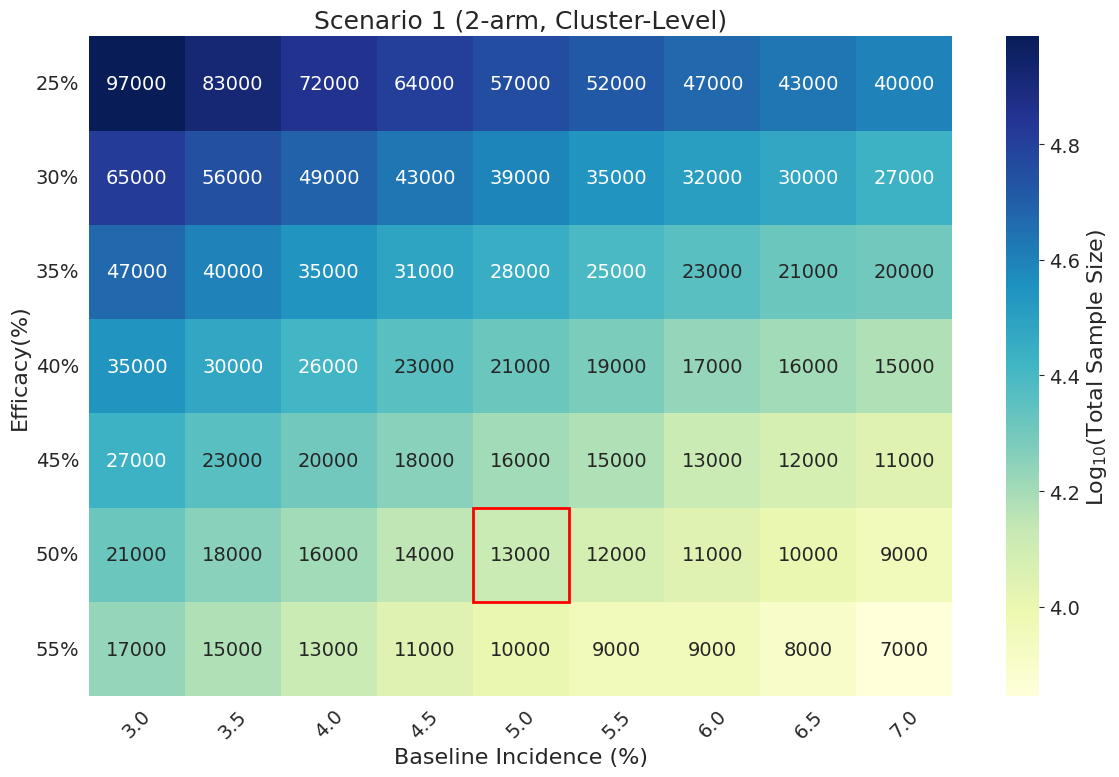

In [4]:
log_s1= np.log10(scenario1_matrix)
fig, ax= plt.subplots(figsize=(12,8))
sns.heatmap(
    log_s1,
    annot=scenario1_matrix.astype(int), fmt="",
    annot_kws={"size":14},
    cmap="YlGnBu",
    xticklabels=[f"{b:.1f}" for b in baseline_incidence_percent],
    yticklabels=[f"{int(e*100)}%" for e in efficacies],
    cbar_kws={"label":"Log$_{10}$(Total Sample Size)"},
    ax=ax
)
ax.set_title("Scenario 1 (2-arm, Cluster-Level)", fontsize=18)
ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
ax.set_ylabel("Efficacy(%)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(labelsize=14)

# Red box => baseline=5 => x=4, efficacy=50 => y=5
rect= Rectangle((4,5),1,1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

# Scenario 2: Household-Level, 2-arm

In [5]:
m_house= 5
r_house= 0.2
DE_house= 1+ (m_house-1)* r_house
print(f"Scenario 2: DE_house={DE_house:.2f}")

def household_size_calc_2arm(p_control, eff, Z_alpha, Z_beta, DE, n_e=5):
    p1= p_control
    p2= p_control*(1-eff)
    delta= p1- p2
    if abs(delta)<1e-12:
        delta=1e-12
    numerator= (Z_alpha+ Z_beta)**2* (p1*(1-p1)+ p2*(1-p2))
    denominator= delta**2
    n_pg= numerator/ denominator
    return n_pg* DE

Z_alpha_2= stats.norm.ppf(1- alpha/2)
scenario2_matrix= np.zeros((len(efficacies), len(baseline_incidences)))

for i, eff in enumerate(efficacies):
    for j, p_control in enumerate(baseline_incidences):
        n_pg= household_size_calc_2arm(
            p_control, eff,
            Z_alpha_2, Z_beta,
            DE_house,
            m_house
        )
        K_per_group= math.ceil(n_pg/m_house)
        tot_households= K_per_group*2
        tot_inds= tot_households* m_house
        scenario2_matrix[i,j]= tot_inds

Scenario 2: DE_house=1.80


### Scenario 2 Heatmap (2-arm, Household-Level)

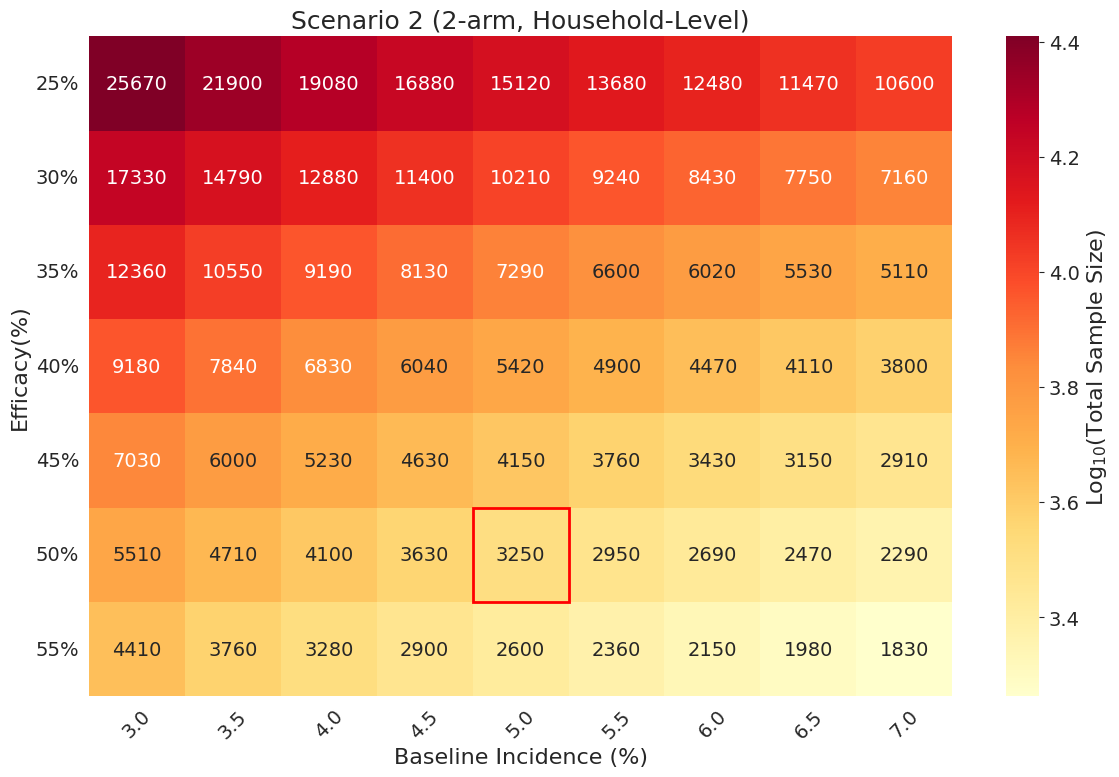

In [6]:
log_s2= np.log10(scenario2_matrix)
fig, ax= plt.subplots(figsize=(12,8))
sns.heatmap(
    log_s2,
    annot=scenario2_matrix.astype(int), fmt="",
    annot_kws={"size":14},
    cmap="YlOrRd",
    xticklabels=[f"{b:.1f}" for b in baseline_incidence_percent],
    yticklabels=[f"{int(e*100)}%" for e in efficacies],
    cbar_kws={"label":"Log$_{10}$(Total Sample Size)"},
    ax=ax
)
ax.set_title("Scenario 2 (2-arm, Household-Level)", fontsize=18)
ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
ax.set_ylabel("Efficacy(%)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(labelsize=14)

# Red box => baseline=5 => x=4, efficacy=50 => y=5
rect= Rectangle((4,5),1,1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

# Scenario 2B: 2-arm Household-Level + Low-BMI Subgroups

We fix **normal-BMI** efficacy at 50%. We vary baseline incidence (3–7 in steps of 0.5) on x-axis, and a multiplier for Low-BMI efficacy (0.5..2.0) on y-axis. The code below **defines** `scenario2B_matrix` so the heatmap can be produced without error.

In [7]:
m_household = 5
r_household = 0.2
DE_household = 1 + (m_household - 1)*r_household
print(f"Scenario 2B (Modified): DE_household={DE_household:.3f}")

def household_size_calc_bmi(
    baseline_inc,  # overall baseline incidence
    eff_base,      # normal-BMI efficacy=50%
    ratio,         # multiplier for low-BMI efficacy
    Z_alpha, Z_beta, DE, n_e=5
):
    """
    Weighted average incidence p2 for the intervention:
      - 25% have 2x baseline incidence => low-BMI
      - 75% have 0.67x baseline incidence => normal-BMI
    Then standard 2-prop formula.
    """
    p1 = baseline_inc  # incidence in Control
    eff_low = eff_base*ratio

    # Low-BMI (25%): 2.0 * baseline_inc, with efficacy=eff_low
    p_low_int = 2.0*baseline_inc*(1 - eff_low)
    # Normal-BMI (75%): 0.67* baseline_inc, efficacy=eff_base
    p_high_int= 0.67*baseline_inc*(1 - eff_base)
    p2= 0.25*p_low_int + 0.75*p_high_int

    # 2-prop sample size.
    delta= p1 - p2
    if abs(delta)<1e-12:
        delta=1e-12
    numerator= (Z_alpha + Z_beta)**2 * (p1*(1-p1)+ p2*(1-p2))
    denominator= delta**2
    n_per_group= numerator/denominator
    n_per_group_adj= n_per_group* DE
    # # households => rounding up => times 2 arms => total individuals.
    K= n_per_group_adj/n_e
    K_per_group= math.ceil(K)
    tot_households= K_per_group* 2
    tot_individuals= tot_households* n_e
    return tot_individuals

# We'll define ratio_values.
ratios= [0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]
scenario2B_matrix= np.zeros((len(ratios), len(baseline_incidences)))

eff_base_2B= 0.50  # normal-BMI efficacy
Z_alpha_2B= stats.norm.ppf(1- alpha/2)

for i, ratio in enumerate(ratios):
    for j, b_inc_percent in enumerate(baseline_incidence_percent):
        b_inc= b_inc_percent/100
        scenario2B_matrix[i,j]= household_size_calc_bmi(
            b_inc,
            eff_base_2B,
            ratio,
            Z_alpha_2B,
            Z_beta,
            DE_household
        )

Scenario 2B (Modified): DE_household=1.800


## Scenario 2B Heatmap

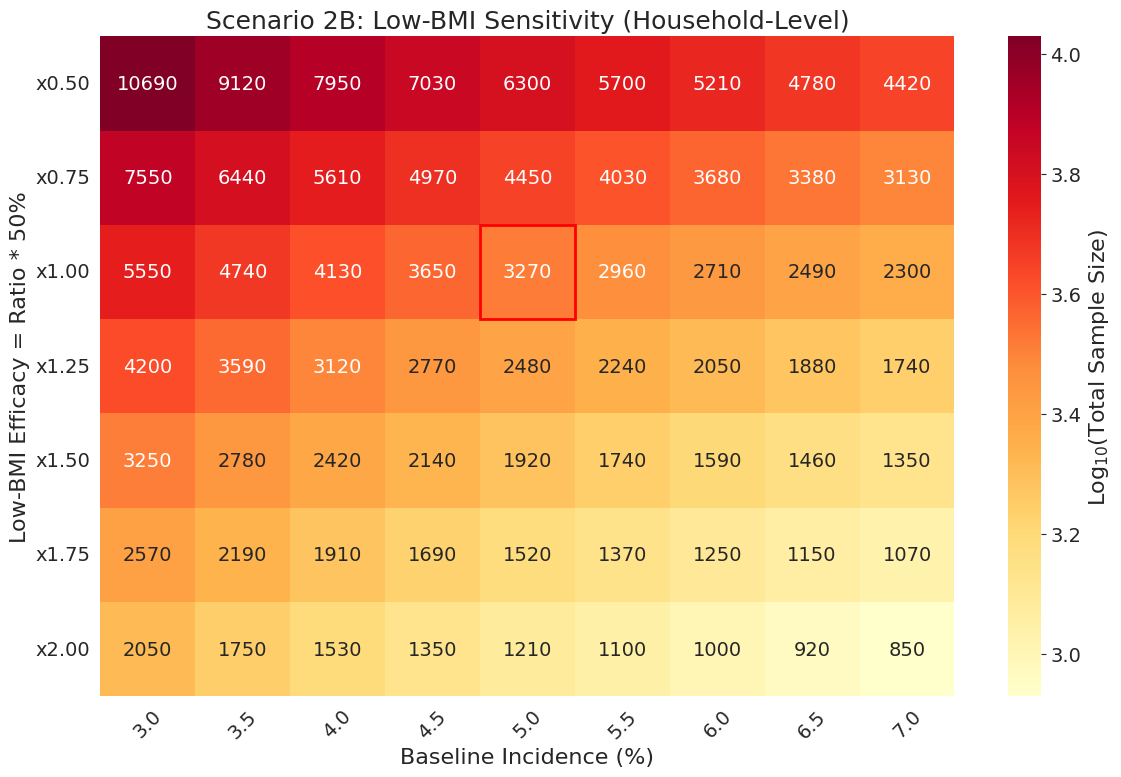

In [15]:
log_2B= np.log10(scenario2B_matrix)
plt.figure(figsize=(12,8))
ax= sns.heatmap(
    log_2B,
    annot=scenario2B_matrix.astype(int),
    annot_kws={"size":14},
    fmt="",
    cmap="YlOrRd",
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"x{r:.2f}" for r in ratios],
    cbar_kws={"label":"Log$_{10}$(Total Sample Size)"}
)
plt.title("Scenario 2B: Low-BMI Sensitivity (Household-Level)", fontsize=18)
plt.xlabel("Baseline Incidence (%)", fontsize=16)
plt.ylabel("Low-BMI Efficacy = Ratio * 50%", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(labelsize=14)

# Red box at baseline=5 => x=4, ratio=1 => y=2
rect= Rectangle((4,2), 1,1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

# Scenario 3: Observed ICC (2-arm, Cluster-Level)
We produce a single heatmap with the smaller, observed ICC from RATIONS. Already done below.

Scenario 3 (2-arm, Observed ICC). DE_cluster_obs= 3.454


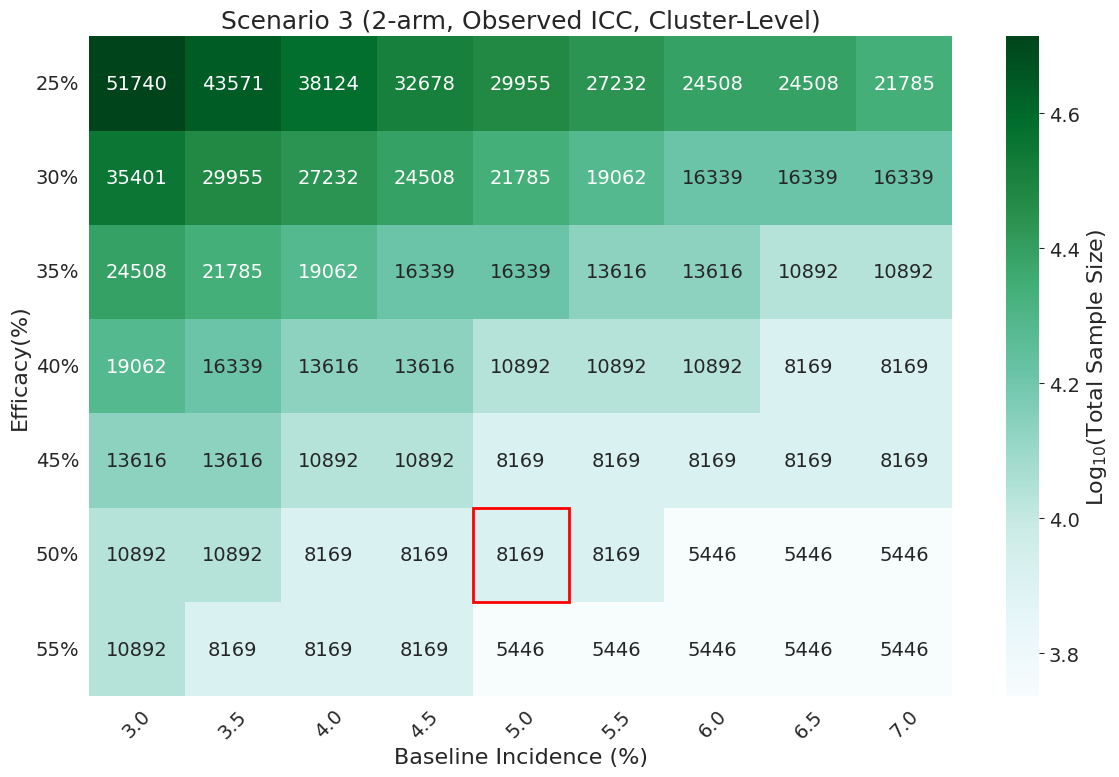

In [9]:
ne_obs= 3.7
ns_obs= 368
r_obs= 0.0036
rho_obs= 0.0018
DE_cluster_obs= 1+ (ne_obs-1)*r_obs + ne_obs*(ns_obs-1)*rho_obs
print(f"Scenario 3 (2-arm, Observed ICC). DE_cluster_obs= {DE_cluster_obs:.3f}")

scenario3_matrix_cluster= np.zeros((len(efficacies), len(baseline_incidences)))
Z_alpha_2arm_obs= stats.norm.ppf(1- alpha/2)
m_obs_cluster= ne_obs* ns_obs

for i, eff in enumerate(efficacies):
    for j,p_control in enumerate(baseline_incidences):
        p1= p_control
        p2= p_control*(1-eff)
        delta= p1- p2
        if abs(delta)<1e-12:
            delta=1e-12
        numerator= (Z_alpha_2arm_obs+Z_beta)**2* (p1*(1-p1)+ p2*(1-p2))
        denom= delta**2
        n_pg= numerator/ denom
        n_pg_adj= n_pg* DE_cluster_obs
        K_per_group= math.ceil(n_pg_adj/ m_obs_cluster)
        total_clusters= K_per_group* 2
        total_inds= total_clusters* m_obs_cluster
        scenario3_matrix_cluster[i,j]= total_inds

# Produce the heatmap.
log3c= np.log10(scenario3_matrix_cluster)
plt.figure(figsize=(12,8))
ax= sns.heatmap(
    log3c,
    annot=scenario3_matrix_cluster.astype(int), fmt="",
    annot_kws={"size":14},
    cmap="BuGn",
    xticklabels=[f"{b:.1f}" for b in baseline_incidence_percent],
    yticklabels=[f"{int(e*100)}%" for e in efficacies],
    cbar_kws={"label":"Log$_{10}$(Total Sample Size)"}
)
ax.set_title("Scenario 3 (2-arm, Observed ICC, Cluster-Level)", fontsize=18)
ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
ax.set_ylabel("Efficacy(%)", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.tick_params(labelsize=14)

# Red box => baseline=5 => x=4, eff=50 => y=5
rect= Rectangle((4,5),1,1, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

# Scenario 4: 3-Arm (Cluster-Level)
Two comparisons vs. Control => \(k=2\). We define `three_arm_heatmap` that computes a single 2D matrix for baseline incidence vs. efficacy. The code is below.

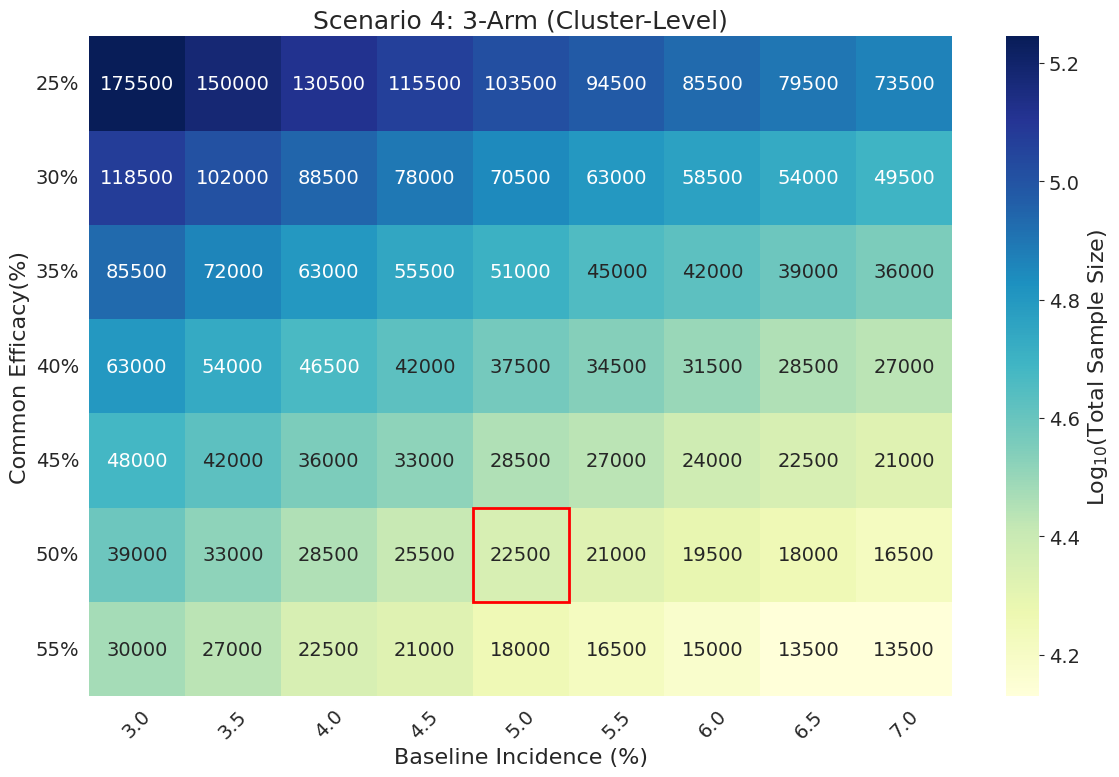

In [23]:
def three_arm_heatmap(
    baseline_incs, effic_arr,
    alpha=0.05, k=2,
    DE=1.0,
    cluster_size=1,
    scenario_name="Scenario 4: 3-Arm Cluster-Level",
    cmap="YlGnBu"
):
    alpha_adj= alpha/k
    matrix= np.zeros((len(effic_arr), len(baseline_incs)))

    for i,eff in enumerate(effic_arr):
        for j, p_control in enumerate(baseline_incs):
            Z_alpha_comp= stats.norm.ppf(1- alpha_adj/2)
            p1= p_control
            p2= p_control*(1-eff)
            delta= p1-p2
            if abs(delta)<1e-12:
                delta=1e-12
            numerator= (Z_alpha_comp+ Z_beta)**2* (p1*(1-p1)+ p2*(1-p2))
            denom= delta**2
            n_pg= numerator/ denom
            n_pg_adj= n_pg* DE
            K_per_group= math.ceil(n_pg_adj/ cluster_size)
            tot_arms=3
            total_clust= K_per_group* tot_arms
            total_inds= total_clust* cluster_size
            matrix[i,j]= total_inds

    fig, ax= plt.subplots(figsize=(12,8))
    log_mat= np.log10(matrix)
    sns.heatmap(
        log_mat,
        annot=matrix.astype(int), fmt="",
        annot_kws={"size":14},
        cmap=cmap,
        xticklabels=[f"{inc*100:.1f}" for inc in baseline_incs],
        yticklabels=[f"{eff*100:.0f}%" for eff in effic_arr],
        cbar_kws={"label":"Log$_{10}$(Total Sample Size)"},
        ax=ax
    )
    ax.set_title(scenario_name, fontsize=18)
    ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
    ax.set_ylabel("Common Efficacy(%)", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    ax.tick_params(labelsize=14)

    # red box => baseline=5 => x=4, effic=50 => y= (0.25..0.55 => index=5)
    rect= Rectangle((4,5),1,1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()
    return matrix

# Cluster-level design effect.
ne=5
ns=100
r=0.2
rho=0.01
DE_3arm_cluster= 1+ (ne-1)*r + ne*(ns-1)* rho
cluster_sz_3cl= ne*ns
scenario4_mat= three_arm_heatmap(
    baseline_incs= baseline_incidences,
    effic_arr= efficacies,
    alpha=0.05,
    k=2,
    DE=DE_3arm_cluster,
    cluster_size=cluster_sz_3cl,
    scenario_name="Scenario 4: 3-Arm (Cluster-Level)"
)

# Scenario 5: 3-Arm (Household-Level)

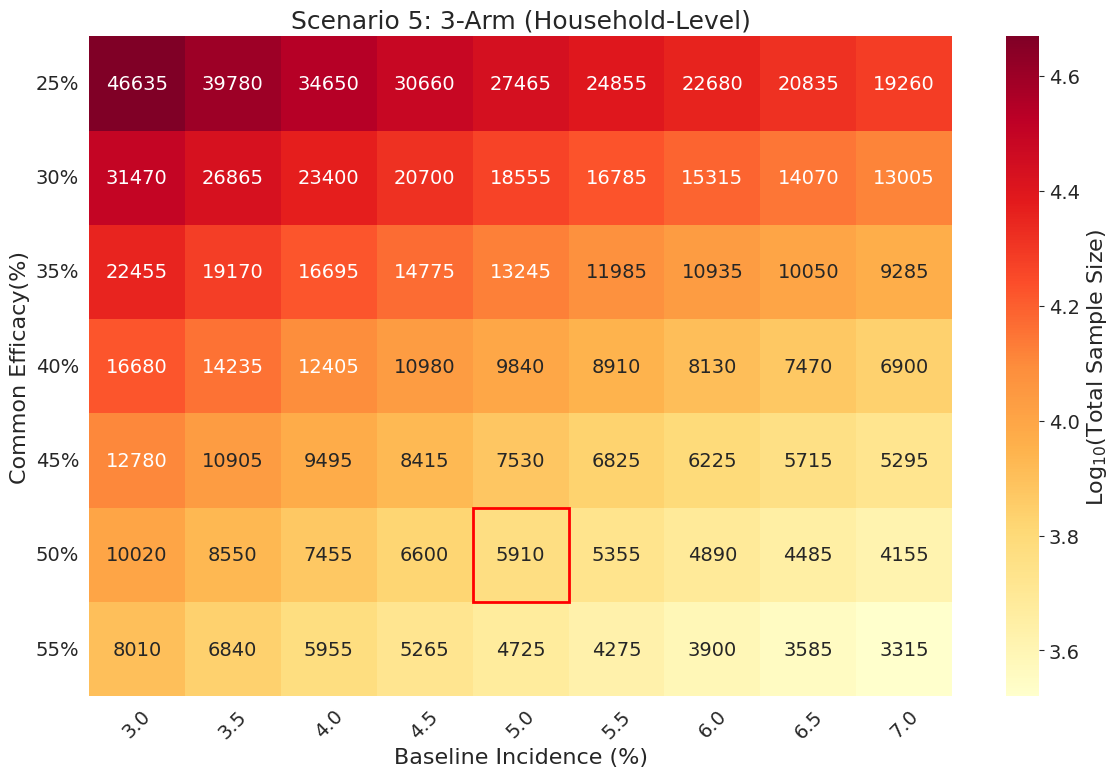

In [24]:
m_house=5
r_house=0.2
DE_3arm_house= 1+ (m_house-1)*r_house
cluster_sz_3hh= m_house

scenario5_mat= three_arm_heatmap(
    baseline_incs= baseline_incidences,
    effic_arr= efficacies,
    alpha=0.05,
    k=2,
    DE= DE_3arm_house,
    cluster_size= cluster_sz_3hh,
    scenario_name="Scenario 5: 3-Arm (Household-Level)",
    cmap="YlOrRd"
)

# Scenario 6: 4-Arm (Cluster-Level)
We define a function `four_arm_heatmap` with `k=3` comparisons vs. Control and produce a single heatmap with baseline incidence x efficacy.

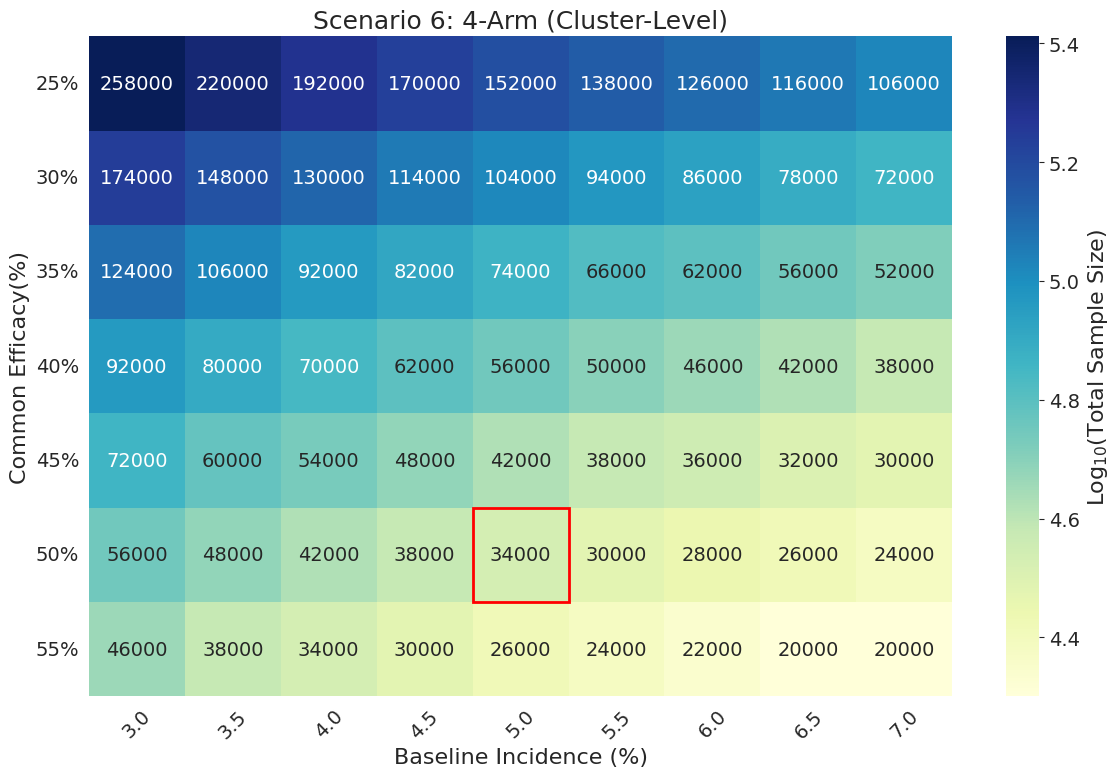

In [26]:
def four_arm_heatmap(
    baseline_incs, effic_arr,
    alpha=0.05,
    k=3,
    DE=1.0,
    cluster_size=1,
    scenario_name="Scenario 6: 4-Arm (Cluster-Level)",
    cmap="YlGnBu"
):
    alpha_adj= alpha/k
    matrix= np.zeros((len(effic_arr), len(baseline_incs)))

    for i,eff in enumerate(effic_arr):
        for j,p_control in enumerate(baseline_incs):
            Z_alpha_comp= stats.norm.ppf(1- alpha_adj/2)
            p1= p_control
            p2= p_control*(1-eff)
            delta= p1-p2
            if abs(delta)<1e-12:
                delta=1e-12
            numerator= (Z_alpha_comp+Z_beta)**2* (p1*(1-p1)+ p2*(1-p2))
            denom= delta**2
            n_pg= numerator/ denom
            n_pg_adj= n_pg*DE
            K_per_group= math.ceil(n_pg_adj/ cluster_size)
            tot_arms=4
            total_clust= K_per_group* tot_arms
            total_inds= total_clust* cluster_size
            matrix[i,j]= total_inds

    fig,ax= plt.subplots(figsize=(12,8))
    log_mat= np.log10(matrix)
    sns.heatmap(
        log_mat,
        annot=matrix.astype(int), fmt="",
        annot_kws={"size":14},
        cmap=cmap,
        xticklabels=[f"{inc*100:.1f}" for inc in baseline_incs],
        yticklabels=[f"{eff*100:.0f}%" for eff in effic_arr],
        cbar_kws={"label":"Log$_{10}$(Total Sample Size)"},
        ax=ax
    )
    ax.set_title(scenario_name, fontsize=18)
    ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
    ax.set_ylabel("Common Efficacy(%)", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    ax.tick_params(labelsize=14)

    # red box => baseline=5 => x=4, efficacy=50 => y=5
    rect= Rectangle((4,5),1,1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    plt.tight_layout()
    plt.show()
    return matrix

# Let's produce scenario6
DE_4arm_cluster= 1+ (ne-1)* r + ne*(ns-1)* rho
cluster_sz_4cl= ne*ns
scenario6_mat= four_arm_heatmap(
    baseline_incs= baseline_incidences,
    effic_arr= efficacies,
    alpha=0.05,
    k=3,
    DE=DE_4arm_cluster,
    cluster_size= cluster_sz_4cl,
    scenario_name="Scenario 6: 4-Arm (Cluster-Level)"
)

# Scenario 7: 4-Arm (Household-Level)
Same approach but with household-level design effect.

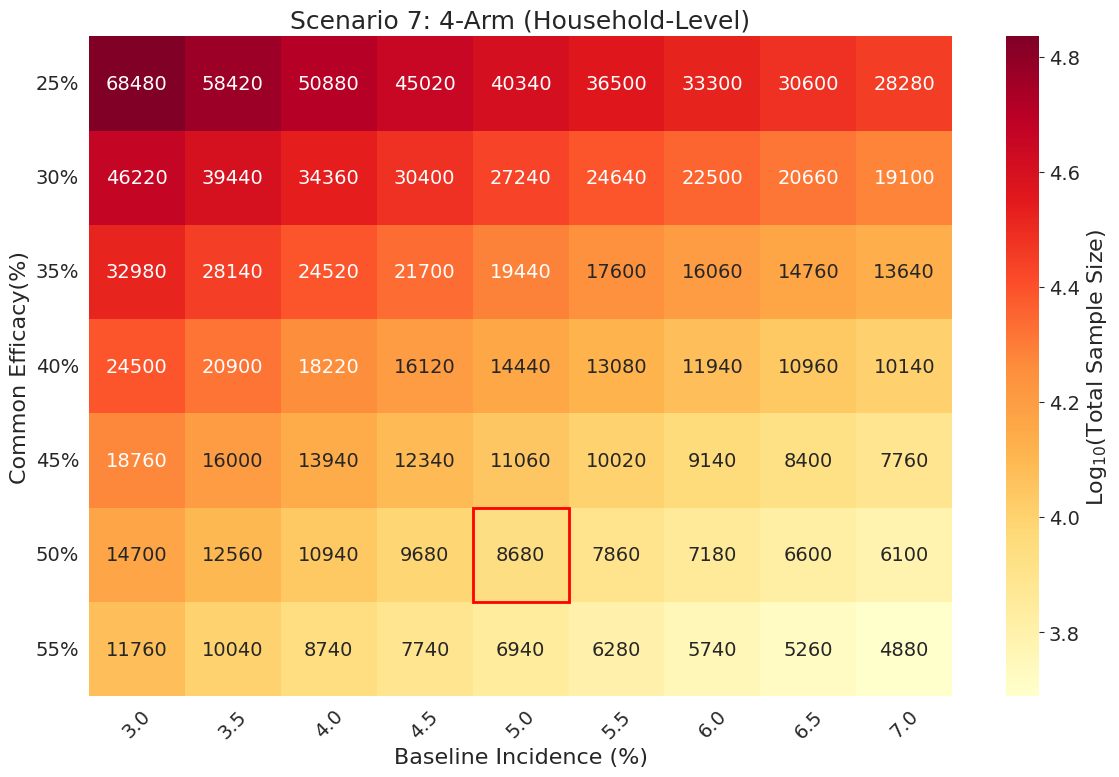

In [27]:
m_house=5
r_house=0.2
DE_4arm_house= 1+ (m_house-1)* r_house
cluster_sz_4hh= m_house

scenario7_mat= four_arm_heatmap(
    baseline_incs= baseline_incidences,
    effic_arr= efficacies,
    alpha=0.05,
    k=3,
    DE=DE_4arm_house,
    cluster_size=cluster_sz_4hh,
    scenario_name="Scenario 7: 4-Arm (Household-Level)",
    cmap="YlOrRd"
)

# Reference Assumption Comparison Table
We now **extract** from each scenario the **total sample size** under the reference assumption: **baseline incidence=5%** (index=4) and **efficacy=50%** (index=5). We'll compile these into a single table for all 7 scenarios.

In [14]:
idx_baseline= 4  # baseline=5% => x=4
idx_efficacy= 5  # efficacy=50% => y=5

ref_s1= scenario1_matrix[idx_efficacy, idx_baseline]
ref_s2= scenario2_matrix[idx_efficacy, idx_baseline]
ref_s3= scenario3_matrix_cluster[idx_efficacy, idx_baseline]
ref_s4= scenario4_mat[idx_efficacy, idx_baseline]
ref_s5= scenario5_mat[idx_efficacy, idx_baseline]
ref_s6= scenario6_mat[idx_efficacy, idx_baseline]
ref_s7= scenario7_mat[idx_efficacy, idx_baseline]

reference_results= {
    "Scenario 1 (2-arm, cluster)": ref_s1,
    "Scenario 2 (2-arm, household)": ref_s2,
    "Scenario 3 (2-arm, obs ICC)": ref_s3,
    "Scenario 4 (3-arm, cluster)": ref_s4,
    "Scenario 5 (3-arm, household)": ref_s5,
    "Scenario 6 (4-arm, cluster)": ref_s6,
    "Scenario 7 (4-arm, household)": ref_s7
}

df_summary= pd.DataFrame(list(reference_results.items()), columns=["Scenario", "Total Sample Size @ (5%,50%)"])
df_summary

,Scenario,"Total Sample Size @ (5%,50%)"
0,"Scenario 1 (2-arm, cluster)",13000.0
1,"Scenario 2 (2-arm, household)",3250.0
2,"Scenario 3 (2-arm, obs ICC)",8169.6
3,"Scenario 4 (3-arm, cluster)",22500.0
4,"Scenario 5 (3-arm, household)",5910.0
5,"Scenario 6 (4-arm, cluster)",34000.0
6,"Scenario 7 (4-arm, household)",8680.0


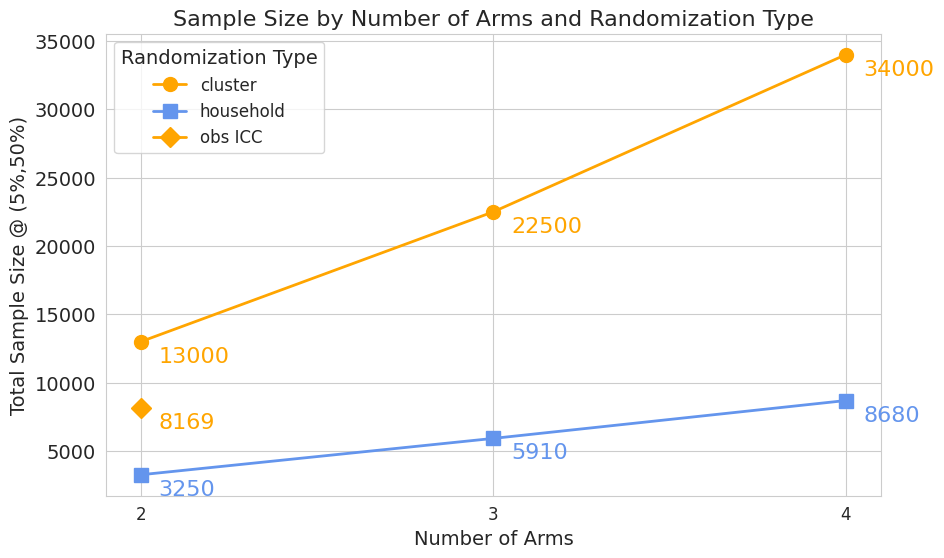

In [46]:
# Extract number of arms and randomization type
df_summary['Number of Arms'] = df_summary['Scenario'].str.extract(r'(\d)-arm').astype(int)
df_summary['Randomization Type'] = df_summary['Scenario'].str.extract(r'(cluster|household|obs ICC)')

# Set marker shapes for different randomization types
marker_shapes = {'cluster': 'o', 'household': 's', 'obs ICC': 'D'}

# Set colors for randomization types
colors = {'cluster': 'orange', 'household': 'cornflowerblue', 'obs ICC': 'orange'}

# Plot the scatter plot
plt.figure(figsize=(10, 6))
# Plot each group and connect points
for randomization_type, group in df_summary.groupby('Randomization Type'):
    group = group.sort_values('Number of Arms')
    plt.plot(group['Number of Arms'],
             group['Total Sample Size @ (5%,50%)'],
             label=randomization_type,
             marker=marker_shapes[randomization_type],
             color=colors[randomization_type],
             markersize=10,
             linestyle='-',
             linewidth=2)

    # Add numeric value labels with slight offset to avoid overlapping with points/lines
    for i, row in group.iterrows():
        plt.text(row['Number of Arms'] + 0.05,
                 row['Total Sample Size @ (5%,50%)'] - 1500,
                 f"{int(row['Total Sample Size @ (5%,50%)'])}",
                 fontsize=16,
                 color=colors[randomization_type])

# Adjust x-axis ticks to be integers
plt.xticks(df_summary['Number of Arms'].unique(), fontsize=12)
plt.title("Sample Size by Number of Arms and Randomization Type", fontsize=16)
plt.xlabel("Number of Arms", fontsize=14)
plt.ylabel("Total Sample Size @ (5%,50%)", fontsize=14)
plt.legend(title="Randomization Type", fontsize=12)
plt.grid(True)

# Save the plot as a PDF
plt.savefig("sample_size_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Interpretation of the Table

1. **Scenario 1 & 2**: 2-arm designs, cluster vs. household.
2. **Scenario 3**: Observed ICC => drastically smaller cluster-level sample sizes.
3. **Scenario 4 & 5**: 3-arm => we have 2 comparisons => sample size is bigger.
4. **Scenario 6 & 7**: 4-arm => 3 comparisons => further increase.

Hence going from 2-arm to 3-arm or 4-arm parallel designs inflates total sample size once we do multiple-comparison correction (Bonferroni) and multiply by total arms. The effect is smaller if we have an observed low ICC (Scenario 3).

# Conclusion

This single notebook merges **2-arm** sample-size scenarios (1,2,2B,3) with **3-arm** (4,5) and **4-arm** (6,7) designs, each tested vs. Control only. We show how multi-arm parallel designs lead to **larger** total sample sizes, especially for higher numbers of comparisons.

**Key Observations**:
- **Household-level** randomization typically yields **lower** design effects => smaller required sample sizes.
- **Observed ICC** can drastically reduce sample sizes (compare Scenario 1 vs. 3, for instance).
- **Scenario 2B**: The sensitivity to low-BMI vs. normal-BMI efficacy can further change total sample sizes.


---
## References

- **Bhargava, A., et al. (2023)**. Nutritional supplementation for TB prevention in India (RATIONS). *The Lancet*.
- **Teerenstra, S., Lu, B., Preisser, J. S., van Achterberg, T., & Borm, G. F. (2010)**. Sample size considerations for GEE analyses of three-level cluster randomized trials. *Biometrics*, 66(4), 1230-1237.
- **Hayes, R. J., & Moulton, L. H. (2017)**. *Cluster Randomised Trials*. CRC Press.

```bash
pip install numpy matplotlib scipy seaborn pandas
```
Open this file in **Jupyter** or **JupyterLab** to run and visualize all the heatmaps and summary.